In [61]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import *

F_geo = lambda x,p: np.floor(np.log(1-x)/np.log(1-p))
f = lambda x,p: p* (1-p)**(x-1)
Trans = lambda x: 10**(-0.2*x/10)
def h(p_list):
    y_list = np.zeros(len(p_list))
    for i,p in enumerate(p_list):
        if p<1e-6 or (1-p)<1e-6:
            y_list[i]= 0
        else:
            y_list[i]= -p*np.log2(p)-(1-p)*np.log2(1-p)
    return y_list

In [2]:

def T_avg_mc_n_rep(links, cct= False,Nmax=10000):
    N_links = len(links)
    τs = links/c
    Ns = np.zeros((N_links,Nmax))
    Ns[0,:] = (2*F_geo(np.random.rand(Nmax),p_link*Trans(links[0]))-1)*τs[0]
    for i in range(1,N_links):
        Ns[i,:] = 2*F_geo(np.random.rand(Nmax),p_link*Trans(links[i]))*τs[i]
    
    Ts = np.zeros((N_links-1,Nmax))
    Ts[0,:] = np.abs(Ns[1,:]-Ns[0,:])+ 2*τs[1]
    for i in range(1,N_links-1):
        Ts[i,:] = np.abs(Ns[i+1,:]-Ns[i,:]+τs[i])+ 2*τs[i+1]
    f_memory_qkd = np.mean(np.exp(-np.sum(Ts,axis=0)/τ_coh))
    if cct: # inclduing classical comm. 
        Tsw = np.zeros((N_links-1,Nmax))
        Tsw[0,:] = np.max([Ns[1,:],Ns[0,:]],axis=0) + np.sum(τs[:1])
        for i in range(1,N_links-1):
            Tsw[i,:] = np.max([Ns[i+1,:],Ns[i,:]-τs[i]],axis=0)+ np.sum(τs[:(i+1)])
            
        T_tot = np.mean(np.max(Tsw,axis=0))           
        Ts_A = np.max(Tsw,axis=0)-Ns[0,:] + τs[0] #np.zeros((1,Nmax))
        Ts_B = np.max(Tsw,axis=0)-Ns[-1,:] + τs[-1] #np.zeros((1,Nmax))
        f_memory = np.mean(np.exp(-(np.sum(Ts,axis=0)+Ts_A+Ts_B)/τ_coh))
    else:
        T_tot = np.mean(np.max(Ns,axis=0))
        Ts_A = np.max(Ns,axis=0)-Ns[0,:] + τs[0] #np.zeros((1,Nmax))
        Ts_B = np.max(Ns,axis=0)-Ns[-1,:] + τs[-1] #np.zeros((1,Nmax))
        f_memory = np.mean(np.exp(-(np.sum(Ts,axis=0)+Ts_A+Ts_B)/τ_coh))

    return T_tot, f_memory, f_memory_qkd


## No repeater

/tmp/ipykernel_386479/829689909.py:21: RuntimeWarning: invalid value encountered in scalar divide
  Tm[i_t] = Nm[i_t]/(1-q1**m)*2*L0/c


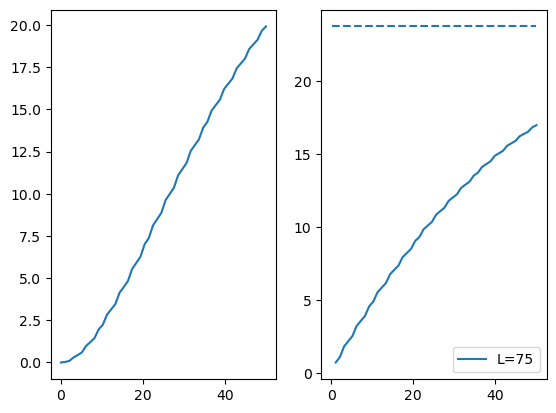

In [93]:
c = 2e5 # speed of light [km/s]
τ_coh = 0.1
p_link= 1
τ_cut_list = np.linspace(0.1,50)*1e-3 # cutoff
# L0_list = np.array([50,100,150,200])/2
L0_list = np.array([150])/2

plt.figure()
# ax1, fig1 = plt.subplot(1)
# ax2, fig = plt.figure(2)

for i_L, L0 in enumerate(L0_list):
    Nm = np.zeros(len(τ_cut_list))
    Tm = np.zeros(len(τ_cut_list))
    for i_t, τ_cut in enumerate(τ_cut_list):
        m = int(τ_cut/(2*L0/c))
        p1 = p_link*Trans(L0)
        q1 = 1-p1
        Nm[i_t] = (1-(1+m*p1)*q1**m)/p1
#         m_vs_t[i_t] = m
        Tm[i_t] = Nm[i_t]/(1-q1**m)*2*L0/c
    plt.subplot(1,2,1)
    plt.plot(τ_cut_list*1e3,Nm,"-",label="L=%d" % L0)
    plt.subplot(1,2,2)
    plt.plot(τ_cut_list*1e3,Tm*1e3,"-",label="L=%d" % L0)
    plt.plot(τ_cut_list*1e3,2000*L0/c/p1+0*τ_cut_list, "--", color = "C%d" % i_L)

# plt.figure(1)
plt.legend()
plt.show()

# plt.figure(2)
# plt.legend()
# plt.show()

# One repeater

# Sequential
## Rate vs. Distance

In [91]:
c = 2e5 # speed of light [km/s]
τ_coh = 0.1
p_link= 1
τ_cut = 10*τ_coh # cutoff

L0_list = np.linspace(10,800,101) # e2e distance [km]
inv_rate_seq = np.zeros(len(L0_list))
f_memory_seq = np.zeros(len(L0_list))
f_memory_qkd_seq = np.zeros(len(L0_list))
inv_rate_seq_cutoff = np.zeros(len(L0_list))
f_memory_seq_cutoff = np.zeros(len(L0_list))
f_memory_qkd_seq_cutoff = np.zeros(len(L0_list))

for i, L0 in enumerate(L0_list):
    L1 = L0/2
    L2 = L0/2
    inv_rate_seq[i] = 2*L1/(c* p_link*Trans(L1))+2*L2/(c* p_link*Trans(L2))
    f_memory_qkd_seq[i] = p_link*Trans(L2)*np.exp(-4*L2/(c*τ_coh))/(1- (1-p_link*Trans(L2))*np.exp(-2*L2/(c*τ_coh)) )
    p1 = p_link*Trans(L1)
    q1= 1-p1 
    τ1 = L1/c
    m = int(τ_cut/(2*τ1))
    P = 1-q1**m
    n_avg = (-m*q1**m*p1+(1-q1**m))/p1/P
    inv_rate_seq_cutoff[i] = 2*τ1/(p1*P)+ ((1/P-1)*m+n_avg)*2*τ1
    f_memory_qkd_seq_cutoff[i] = p1*np.exp(-4*τ1/τ_coh)*(1- (q1*np.exp(-2*τ1/τ_coh))**m )/(1- q1*np.exp(-2*τ1/τ_coh) )/(1- q1**m)


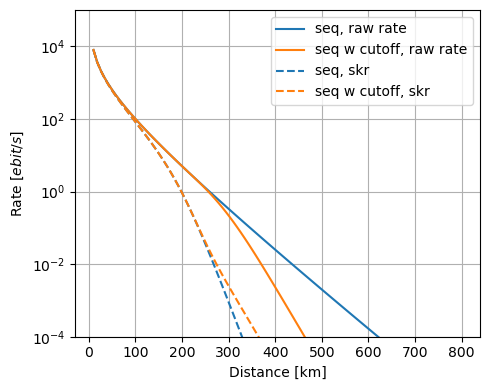

In [92]:
f_qkd_seq = 0.5-0.5*f_memory_qkd_seq
f_qkd_seq_cutoff = 0.5-0.5*f_memory_qkd_seq_cutoff
plt.figure(figsize=(5,4))
# plt.plot(L0_list,-np.log2(1-Trans(L0_list)),"k--", label="PLOB")
plt.plot(L0_list,1/inv_rate_seq,"-",color="C0", label="seq, raw rate")
plt.plot(L0_list,1/inv_rate_seq_cutoff,"-",color="C1", label="seq w cutoff, raw rate")
plt.plot(L0_list,(1-h(f_qkd_seq))/inv_rate_seq,"--",color="C0", label="seq, skr")
plt.plot(L0_list,(1-h(f_qkd_seq_cutoff))/inv_rate_seq_cutoff,"--",color="C1", label="seq w cutoff, skr")
plt.yscale("log")
plt.xlabel("Distance [km]")
plt.ylabel(r"Rate $[ebit/s]$")
plt.ylim([1e-4,1e5])
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig("figures_realtime/one_repeater_no_cutoff.pdf")
plt.show()


# f_par = 0.5-0.5*f_memory_par#np.exp(-memory_time_par/τ_coh)
# f_seq = 0.5-0.5*f_memory_seq#np.exp(-memory_time_seq/τ_coh)
# plt.figure(figsize=(4,3))
# plt.plot(L0_list,1-f_par,"-", label="par")
# plt.plot(L0_list,1-f_seq,"-", label="seq")
# # plt.yscale("log")
# plt.xlabel("Distance [km]")
# # plt.ylabel(r"$T_{mem}/τ_{coh}$")
# plt.ylabel("Fidelity")
# plt.grid()
# plt.legend()
# plt.tight_layout()
# # plt.savefig("figures_realtime/one_repeater_fidelity_no_cutoff.pdf")
# plt.show()


# Real-time simulation

In [270]:
def T_avg_one_repeater(L1,L2,Nmax=100000):
    τ1 = L1/c
    τ2 = L2/c
    p1 = p_link*Trans(L1)
    p2 = p_link*Trans(L2)
#     N1 = F_geo(np.random.rand(Nmax),p1)
    N1 = F_geo(np.random.uniform(low=p1, high=1, size=(Nmax,)),p1)
    N2 = F_geo(np.random.uniform(low=p2, high=1, size=(Nmax,)),p2)
#     N2 = F_geo(np.random.rand(Nmax),p2)
    m = int(τ_cut/(2*τ2))
    succ_inds = np.argwhere(N2<=m)
    fail_inds = np.argwhere(N2>m)
#     print(np.shape(N1[succ_inds]),np.shape(N1[fail_inds]))
    T_succ = 2*np.sum(N1[succ_inds]*τ1+N2[succ_inds]*τ2)
#     T_fail = 2*np.sum(N1[fail_inds]*τ1+m*τ2)
    T_fail = np.sum(2*N1[fail_inds]*τ1+τ_cut)
    T_tot = (T_succ+T_fail)/len(succ_inds)
#     T_tot = 2*np.mean(N1)*τ1
#     print(len(fail_inds)/Nmax)
#     Ts = np.max(np.array([(2*N1-1)*τ1,2*N2*τ2]),axis=0)
#     T_tot = τ1 + np.mean(Ts)
#     f_memory = np.mean(np.exp(-(4*Ts-(4*N1-5)*τ1-(4*N2-3)*τ2)/τ_coh))
#     f_memory_qkd = np.mean(np.exp(-(2*Ts-(2*N1-1)*τ1-(2*N2-2)*τ2)/τ_coh))
    return T_tot #, f_memory, f_memory_qkd


In [273]:
c = 2e5 # speed of light [km/s]
τ_coh = 0.01
p_link= 1
τ_cut = 0.5*τ_coh # cutoff

L0_list = np.linspace(10,200,41) # e2e distance [km]
inv_rate_seq = np.zeros(len(L0_list))
f_memory_qkd_seq = np.zeros(len(L0_list))
inv_rate_seq_cutoff = np.zeros(len(L0_list))
f_memory_qkd_seq_cutoff = np.zeros(len(L0_list))

inv_rate_seq_cutoff_realtime = np.zeros(len(L0_list))
f_memory_qkd_seq_cutoff_realtime = np.zeros(len(L0_list))

for i, L0 in enumerate(L0_list):
    L1 = L0/2
    L2 = L0/2
    inv_rate_seq[i] = 2*L1/(c* p_link*Trans(L1))+2*L2/(c* p_link*Trans(L2))
#     f_memory_qkd_seq[i] = p_link*Trans(L2)*np.exp(-4*L2/(c*τ_coh))/(1- (1-p_link*Trans(L2))*np.exp(-2*L2/(c*τ_coh)) )
    p1 = p_link*Trans(L1)
    q1= 1-p1 
    τ1 = L1/c
    m = int(τ_cut/(2*τ1))
    P = 1-q1**m
#     print(q1,m)
#     n_avg = (-m*q1**m*p1+(1-q1**m))/p1/P
    n_avg = (1-(1+m*p1)*q1**m)/p1/P
#     inv_rate_seq_cutoff[i] = 2*τ1/(p1*P)+ ((1/P-1)*m+n_avg)*2*τ1
    inv_rate_seq_cutoff[i] = 2*τ1/(p1*P)+ (1/P-1)*τ_cut+n_avg*2*τ1
#     f_memory_qkd_seq_cutoff[i] = p1*np.exp(-4*τ1/τ_coh)*(1- (q1*np.exp(-2*τ1/τ_coh))**m )/(1- q1*np.exp(-2*τ1/τ_coh) )/(1- q1**m)
    inv_rate_seq_cutoff_realtime[i] = T_avg_one_repeater(L1,L2)

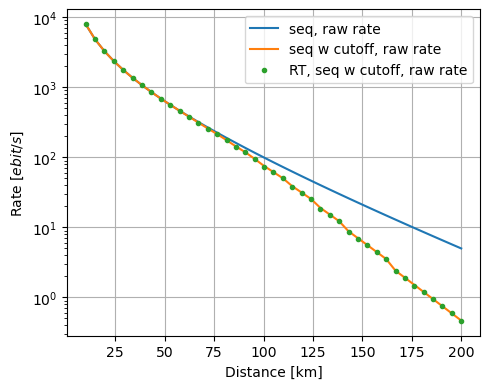

In [274]:
# f_qkd_seq = 0.5-0.5*f_memory_qkd_seq
# f_qkd_seq_cutoff = 0.5-0.5*f_memory_qkd_seq_cutoff
plt.figure(figsize=(5,4))
# plt.plot(L0_list,-np.log2(1-Trans(L0_list)),"k--", label="PLOB")
plt.plot(L0_list,1/inv_rate_seq,"-",color="C0", label="seq, raw rate")
plt.plot(L0_list,1/inv_rate_seq_cutoff,"-",color="C1", label="seq w cutoff, raw rate")
plt.plot(L0_list,1/inv_rate_seq_cutoff_realtime,".",color="C2", label="RT, seq w cutoff, raw rate")
plt.yscale("log")
plt.xlabel("Distance [km]")
plt.ylabel(r"Rate $[ebit/s]$")
# plt.ylim([1e-4,1e5])
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig("figures_realtime/one_repeater_no_cutoff.pdf")
plt.show()

In [230]:
c = 2e5 # speed of light [km/s]
τ_coh = 0.1
p_link= 1
τ_cut = 0.02*τ_coh # cutoff

L0 = 10

L1 = L0/2
L2 = L0/2
p1 = p_link*Trans(L1)
q1= 1-p1 
τ1 = L1/c
m = int(τ_cut/(2*τ1))
P = 1-q1**m
print(q1,m, P)
n_avg = (1-(1+m*p1)*q1**m)/p1/P
inv_rate_seq_cutoff = 2*τ1/(p1*P)+ ((1/P-1)*m+n_avg)*2*τ1
inv_rate_seq = 2*L1/(c* p_link*Trans(L1))+2*L2/(c* p_link*Trans(L2))

Nmax_list = np.logspace(2,5,10)
inv_rate_seq_cutoff_realtime = np.zeros(len(Nmax_list))
for i, Nmax in enumerate(Nmax_list):
    inv_rate_seq_cutoff_realtime[i] = T_avg_one_repeater(L1,L2,int(Nmax))

0.2056717652757185 400 1.0


Text(0.5, 0, 'N_m')

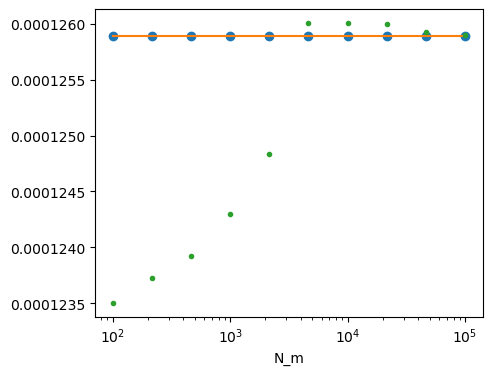

In [231]:
plt.figure(figsize=(5,4))
plt.plot(Nmax_list,Nmax_list*0+inv_rate_seq,"o",color="C0", label="seq, raw rate")
plt.plot(Nmax_list,Nmax_list*0+inv_rate_seq_cutoff,"-",color="C1", label="seq w cutoff, raw rate")
plt.plot(Nmax_list,inv_rate_seq_cutoff_realtime,".",color="C2", label="RT, seq w cutoff, raw rate")
# plt.yscale("log")
plt.xscale("log")
plt.xlabel("N_m")


## n repeaters

In [18]:
c = 2e5 # speed of light [km/s]
τ_coh = 0.1
p_link= 1
n = 2 # number of elementary links (i.e., one rep -> n=2)

# L0_list = np.linspace(10,800,101) # e2e distance [km]
L0_list= [247] 
inv_rate_par_2 = np.zeros(len(L0_list))
f_memory_par_2 = np.zeros(len(L0_list))
f_memory_qkd_par_2 = np.zeros(len(L0_list))
inv_rate_seq_2 = np.zeros(len(L0_list))
f_memory_seq_2 = np.zeros(len(L0_list))
f_memory_qkd_seq_2 = np.zeros(len(L0_list))
for i, L0 in enumerate(L0_list):
#     L1 = L0/2
#     L2 = L0/2
    Ls = np.array([L0/n]*n)
#     inv_rate_par[i], memory_time_par[i], memory_time_qkd_par[i] = T_avg_mc(L1,L2,Nmax=100000)
    inv_rate_par_2[i],f_memory_par_2[i],f_memory_qkd_par_2[i] = T_avg_mc_n_rep(Ls,cct=True,Nmax=10000)
    inv_rate_seq_2[i] = np.sum(2*Ls/(c* p_link*Trans(Ls)))
#     memory_time_seq_2[i] = 3*L0/c + 4*np.sum(2*Ls[1:]/(c* p_link*Trans(Ls[1:])))
#     memory_time_qkd_seq[i] = 2*(1/(p_link*Trans(L2))+1)*L2/c
    f_memory_seq_2[i] = np.exp(-3*L0/c/τ_coh) *np.prod(p_link*Trans(Ls[1:])*np.exp(-4*Ls[1:]/(c*τ_coh))/(1- (1-p_link*Trans(Ls[1:]))*np.exp(-4*Ls[1:]/(c*τ_coh)) ) )
    f_memory_qkd_seq_2[i] = np.prod( p_link*Trans(Ls[1:])*np.exp(-4*Ls[1:]/(c*τ_coh))/(1- (1-p_link*Trans(Ls[1:]))*np.exp(-2*Ls[1:]/(c*τ_coh)) )  )


In [16]:
f_qkd_par_2 = 0.5-0.5*f_memory_qkd_par_2#np.exp(-memory_time_qkd_par/τ_coh)
f_qkd_seq_2 = 0.5-0.5*f_memory_qkd_seq_2#np.exp(-memory_time_qkd_seq/τ_coh)
plt.figure(figsize=(5,4))
# plt.plot(L0_list,-np.log2(1-Trans(L0_list)),"k--", label="PLOB")
plt.plot(L0_list,p_link*Trans(L0_list)/(2*L0_list/c),"k--", label="DT")
plt.plot(L0_list,1/inv_rate_par_2,"-",color="C0", label="par %d, raw rate" % n)
# plt.plot(L0_list,1/inv_rate_par,"-",color="C1", label="par, raw rate")
plt.plot(L0_list,(1-h(f_qkd_par_2))/inv_rate_par_2,"--",color="C0", label="par %d, skr" % n)
# plt.plot(L0_list,(1-h(f_qkd_par))/inv_rate_par,"--",color="C1", label="par, skr")
plt.plot(L0_list,1/inv_rate_seq_2,"-",color="C1", label="seq %d, raw rate" % n)
plt.plot(L0_list,(1-h(f_qkd_seq_2))/inv_rate_seq_2,"--",color="C1", label="seq %d, skr" % n)
# plt.plot(L0_list,(1-h(f_qkd_seq))/inv_rate_seq,"-.",color="C0", label="seq %d, skr" % n)
plt.yscale("log")
plt.xlabel("Distance [km]")
plt.ylabel(r"Rate $[ebit/s]$")
plt.ylim([1e-3,1e5])
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig("figures_realtime/one_repeater_no_cutoff.pdf")
plt.show()


# f_par_2 = 0.5-0.5*f_memory_par_2#np.exp(-memory_time_par/τ_coh)
# # f_seq = 0.5-0.5*f_memory_seq#np.exp(-memory_time_seq/τ_coh)
# plt.figure(figsize=(4,3))
# plt.plot(L0_list,1-f_par_2,"-", label="par")
# plt.plot(L0_list,1-f_par,"-", label="par %d" % n)
# # plt.plot(L0_list,1-f_seq,"-", label="seq")
# # plt.yscale("log")
# plt.xlabel("Distance [km]")
# # plt.ylabel(r"$T_{mem}/τ_{coh}$")
# plt.ylabel("Fidelity")
# plt.grid()
# plt.legend()
# plt.tight_layout()
# # plt.savefig("figures_realtime/one_repeater_fidelity_no_cutoff.pdf")
# plt.show()


TypeError: can't multiply sequence by non-int of type 'float'

<Figure size 500x400 with 0 Axes>

In [21]:
f_e2e = 0.5+0.5*f_memory_qkd_seq_2
ex = 1- f_e2e
print(ex)

[0.39418755]


## parallel

In [275]:
def T_avg_one_repeater(L1,L2,Nmax=10000):
    τ1 = L1/c
    τ2 = L2/c
    p1 = p_link*Trans(L1)
    p2 = p_link*Trans(L2)
    N1 = F_geo(np.random.uniform(low=p1, high=1, size=(Nmax,)),p1)
    N2 = F_geo(np.random.uniform(low=p2, high=1, size=(Nmax,)),p2)
    Ts = np.max(np.array([(2*N1-1)*τ1,2*N2*τ2]),axis=0)
    T_tot = τ1 + np.mean(Ts)
    f_memory = np.mean(np.exp(-(4*Ts-(4*N1-5)*τ1-(4*N2-3)*τ2)/τ_coh))
    f_memory_qkd = np.mean(np.exp(-(2*Ts-(2*N1-1)*τ1-(2*N2-2)*τ2)/τ_coh))
    return T_tot, f_memory, f_memory_qkd

def T_avg_par_one_repeater(L1,L2,τ_cut,Nmax=100000):
    τ1 = L1/c
    τ2 = L2/c
    p1 = p_link*Trans(L1)
    p2 = p_link*Trans(L2)
    N1 = F_geo(np.random.uniform(low=p1, high=1, size=(Nmax,)),p1)
    N2 = F_geo(np.random.uniform(low=p2, high=1, size=(Nmax,)),p2)
    Ts = np.max(np.array([(2*N1-1)*τ1,2*N2*τ2]),axis=0)
    inds1 = np.argwhere( Ts-(2*N1-1)*τ1 <= τ_cut )[:,0]
    inds2 = np.argwhere( Ts-2*(N2-1)*τ2 <= τ_cut )[:,0]
    succ_inds = np.intersect1d(inds1,inds2)
    T_succ = np.sum(Ts[succ_inds]+ τ1) 
#     fail_inds = set(range(Nmax)) - succ_inds
    T_fail = (2*τ1/p1 + τ_cut)*(Nmax-len(succ_inds))
    T_tot = (T_succ+T_fail)/len(succ_inds)

#     f_memory = np.mean(np.exp(-(4*Ts-(4*N1-5)*τ1-(4*N2-3)*τ2)/τ_coh))
#     f_memory_qkd = np.mean(np.exp(-(2*Ts-(2*N1-1)*τ1-(2*N2-2)*τ2)/τ_coh))
    return T_tot #, f_memory, f_memory_qkd


In [276]:
c = 2e5 # speed of light [km/s]
τ_coh = 0.01
p_link= 1
τ_cut = 0.5*τ_coh # cutoff

L0_list = np.linspace(10,200,41) # e2e distance [km]
inv_rate_par = np.zeros(len(L0_list))
# f_memory_qkd_seq = np.zeros(len(L0_list))
inv_rate_par_cutoff = np.zeros(len(L0_list))
# f_memory_qkd_seq_cutoff = np.zeros(len(L0_list))

# inv_rate_seq_cutoff_realtime = np.zeros(len(L0_list))
# f_memory_qkd_seq_cutoff_realtime = np.zeros(len(L0_list))

for i, L0 in enumerate(L0_list):
    L1 = L0/2
    L2 = L0/2
    inv_rate_seq[i] = 2*L1/(c* p_link*Trans(L1))+2*L2/(c* p_link*Trans(L2))
#     f_memory_qkd_seq[i] = p_link*Trans(L2)*np.exp(-4*L2/(c*τ_coh))/(1- (1-p_link*Trans(L2))*np.exp(-2*L2/(c*τ_coh)) )
    p1 = p_link*Trans(L1)
    q1= 1-p1 
    τ1 = L1/c
    m = int(τ_cut/(2*τ1))
    P = 1-q1**m
#     print(q1,m)
#     n_avg = (-m*q1**m*p1+(1-q1**m))/p1/P
    n_avg = (1-(1+m*p1)*q1**m)/p1/P
    inv_rate_par[i], _, _ = T_avg_one_repeater(L1,L2)
#     f_memory_qkd_seq_cutoff[i] = p1*np.exp(-4*τ1/τ_coh)*(1- (q1*np.exp(-2*τ1/τ_coh))**m )/(1- q1*np.exp(-2*τ1/τ_coh) )/(1- q1**m)
    inv_rate_par_cutoff[i] = T_avg_par_one_repeater(L1,L2,τ_cut)
    

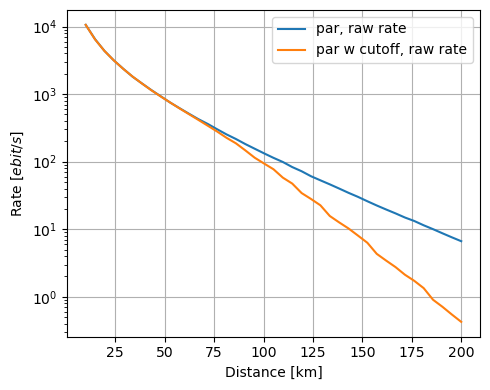

In [277]:
# f_qkd_seq = 0.5-0.5*f_memory_qkd_seq
# f_qkd_seq_cutoff = 0.5-0.5*f_memory_qkd_seq_cutoff
plt.figure(figsize=(5,4))
# plt.plot(L0_list,-np.log2(1-Trans(L0_list)),"k--", label="PLOB")
plt.plot(L0_list,1/inv_rate_par,"-",color="C0", label="par, raw rate")
plt.plot(L0_list,1/inv_rate_par_cutoff,"-",color="C1", label="par w cutoff, raw rate")
# plt.plot(L0_list,1/inv_rate_seq_cutoff_realtime,".",color="C2", label="RT, seq w cutoff, raw rate")
plt.yscale("log")
plt.xlabel("Distance [km]")
plt.ylabel(r"Rate $[ebit/s]$")
# plt.ylim([1e-4,1e5])
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig("figures_realtime/one_repeater_no_cutoff.pdf")
plt.show()